## 

# Conway's Game of Life
<p align="center">
<img src="GoL_table.png" alt="drawing" width="200" />
</p>
The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

1. **Underpopulation/Exposure**: Any live cell with fewer than two live neighbours dies.
2. **Overpopulation/Overcrowding**: Any live cell with more than three live neighbours dies.
3. **Stasis**: Any live cell with two or three live neighbours lives, unchanged, to the next generation.
4. **Reproduction**: Any dead cell with exactly three live neighbours will come to life.

The initial pattern constitutes the 'seed' of the system. The first generation is created by applying the above rules simultaneously to every cell in the seed — births and deaths happen simultaneously, and the discrete moment at which this happens is sometimes called a tick/generation. The rules continue to be applied repeatedly to create further generations.




## A Simple Implementation
Ignoring the complexities of loading patterns and display output, the basic algorithm for the GoL can be very simple. 

A naive approach to a simulating the GoL would be to go through every cell, check for any alive neighbours, and determine the state of the cell in the next generation. While this would work, it would be inefficient for larger grid sizes where only a small coordinate group of livecells may be found. If we had an infinitely sized board of infinately growing livecells, an iterative solution (shown below) by scanning all cells would grow expoentially slow. There are a few solutions around this which have implications to how the cells interact generation-to-generation, and for animation purposes. A few solutions are present:

1. Using a sparse matrix that can change size, expanding in any direction to contain all the live cells.
2. Using a set of live cells, where a live cell is represented by its (x,y) coordinate in the 1D board. 

If we have a collection of “live” cells stored as (x,y) pairs, a simple Python program to compute the next generation is shown:

In [42]:
import collections
'''
1.  By iteratively tallying coordinates surrounding the alive cell itself, we can determine the number of connections that the coordinate
has to an alive cell. If there are three occurances of the coordinates counted, we know exactly that the coordinate will be alive in the 
next generation. If there are less, or more than three connections for the coordinate, we know its going to die of underpopulation, or 
overpopulation, respectively.
2.  Now that we have a set of coordinates with the number of connections (i.e., the occurance of cells surrounding an alive cell in the
initial generation), we can filter out only for the alive cells in the next generation by assigning a "Discrete Transform Function"
according to the table below. "Transform states" 2 & 3 only convert to a live cell in the next generation.

Original | New | Transform State
    0       0           0           (Underpopulation)
    1       0           1           (Overpopulation)
    0       1           2           (Reproduction)
    1       1           3           (Stasis)
'''

def gameOfLifeInfinite(live,generations):
    for i in range(generations):   
        print(live)
        # count alive neighbouring cells except for the alive cell itself, we ignore bounds for an infinite board 
        ctr = collections.Counter((I, J) for r, c in live for I in range(r-1, r+2) for J in range(c-1, c+2) if I != r or J != c) 
        # return a set of coordinates with the newest generation of live cells according to transform states 2 & 3
        live = {ij for ij in ctr if ctr[ij] == 3 or ctr[ij] == 2 and ij in live} 

Given the input provided in the sample input test case, we can see that the two live cells in the extreme bottom left of the universe dies from exposure. Note that Python3 implements infinite-precision arithmetic and is not bound by CPU registry limitations (64-bit level numbers). Rather Python3's numbering is limited by system RAM limitations. Let's note this as a feature of Python, as we don't need to play around with "unsigned long long" types in C/C++.

In [32]:
live = sorted({(0, 1), (1, 2), (2, 0), (2, 1), (2, 2), (-2**64, -2**64), (-2**64+1, -2**64+1)})

generations = 3
gameOfLifeInfinite(live,generations)

[(-18446744073709551616, -18446744073709551616), (-18446744073709551615, -18446744073709551615), (0, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
{(1, 2), (2, 1), (3, 1), (2, 2), (1, 0)}
{(1, 2), (3, 1), (2, 0), (2, 2), (3, 2)}


The previously given simple algorithm runs at ~10,000 generations per second on my Macbook M1 Pro, so it should be easily fast enough to animate a large BOUNDED 256 x 256 universe at 30 generations per second. If all we want is a pretty animation (and ignore loading and saving patterns), there’s likely to be no reason to do anything more complicated. But given we are handling large integers we have to assume that we may encounter large patterns in future generations, so lets try to entertain a faster implementation. But what happens if there are no bounds? How can our Cellular Automation scale up with time and memory?

## An Advanced Implementation



**An Algorithm for Compressing Space & Time**

|<img src ="quadtree_steps.png" alt="drawing" width="200"/>|
|:--:|
|*A representation of a 2-D [Bounding Volume Hierarchy](https://en.wikipedia.org/wiki/Bounding_volume_hierarchy), the [Quadtree](https://en.wikipedia.org/wiki/Quadtree)*|

For advanced implementations of Conway's Game of Life, we will focus on calculating subsequent generations, ignoring the impact on other operations such as animating the pattern, or dynamically inserting new patterns. Since we are exploring an algorithmic solution, Python works as a perfect testbed without the worries of integer overflows. However, it would be important to point out some inherent benefits (i.e., to cell generation speed and memory management) in utilizing an alternative language like C/C++. Accelerating Conway's GoL using carefully written C++ code/intrinsics may yield higher performance by using Single Instruction Multiple Data (SIMD) instructions.  

For instance, if we were to represent a cell state in 4-bits as shown in the transform states above (i.e., in a unsigned long long 2D array), we could possibly represent 16-cell states in 64-bit wide words (SSE). Naively speaking, this would allow us to pack 16-neighbor cell counts in a single 64-bit word representation, allowing us to calculate 16 resulting cells. Using explicit SIMD instructions to increase our register size to 256 bits (AVX2), or 512 bits (AVX-512) may potentially lead to further doubling in performance. 

However...


|<img src = "Conways_game_of_life_breeder_animation.gif" width="400"/>|
|:--:| 
|*A Breeder*|

A "breeder" is a pattern that exhibits quadratic growth, by generating multiple copies of a secondary pattern, each of which then generates multiple copies of a tertiary pattern. "For this pattern, space increases at O(n^2) and computation time increases at O(n^3), so computing the pattern at generation 2n takes eight times as much time as computing the pattern at generation n." [[1]](https://www.gathering4gardner.org/g4g13gift/math/RokickiTomas-GiftExchange-LifeAlgorithms-G4G13.pdf)

Having an input of this pattern would quickly drown out performance gains from modern SIMD, or parallelism implementations. So wait. How do we approach a pattern like this?! In short, HashLife is an algorithm that speeds up the computation of the GoL by factors of thousands, millions, billions and, as a matter of fact, as much as you need it to (and have resources to do it).

## Gosper's Algorithm (Hashlife)

The "big idea" in Gosper's Hashlife algorithm is the ability of exploiting regularity in Game of Life patterns by caching the future of various sub-patterns. In essence, Hashlife is an algorithm that spatially memoizes (caches repetitive results) as divided directed acyclic graphs in the form of a quadtree.

To get a basic idea:
1. We organize the life board in a quadtree, where each block is subdivided into nw-ne-sw-se quadrants, down to its base case where there is only one-remaining time step to compute.
2. Make each block immutable, and canonicalize all the blocks. This canonicalization takes place all the way to the root. Canonicalizing the nodes requires a simple hash set with the usual recurrence on trees; once the nodes are canonicalized, the value of a node is completely represented (including for comparison) by the pointer to that node, so the hash function of a node can be as simple as some mixing of the addresses of the four subnodes. 
3. Recursively implement a method "center" that computes a halfed-sized quadtree child block at the center of the parent block.
4. Memoize "center" results to minimize repetitve work.

It turns out that canonicalization results in incredible space compression, and memoization results in incredible time compression, so that after patterns play out for enough generations, you can easily compute doubling-sized and doubling-generation boards with only a constant amount of work. It's a rare example of an exponentially fast algorithm.

|<img src = "quadtree2.png" width="300"/>|
|:--:| 
|*A representation of quadtree compression into canoncialized blocks*|


For Game of Life, there are only two level-one (or k=0, whereby 2^k*2^k = 1x1) nodes:

    1 (alive) - 0 (dead)

and sixteen level-two (2x2) nodes, represented by an alphabet (hash):

    A   B   C   D   E   F   G   H   I   J   K   L   M   N   O   P   
    11  11  11  11  10  10  10  10  01  01  01  01  00  00  00  00
    11  10  01  00  11  10  01  00  11  10  01  00  11  10  01  00

and 64 level-three (4x4) nodes, further represented by a matrix of hashes:

    1100        BN
    1010  ===>  OF
    0010
    0110

Since the neighbourhood in Game of Life is computed from a 3x3 grid (recall the simple implementation above), every level-three node (4x4) can store the level-two (2x2) future of its center (2x2):

    1100        BN       01     
    1010  ===>  OF ===>  01 ===> K  
    0010
    0110

i.e., the level-three nodes (4x4) "BNOF" has a central future of "K". This can be generalized to any node (enters our recursive property): a level-n node can store the level-(n-1) future of its center, until it meets a base-case. 

However, nodes of a level > 3 (4x4) have to **stitch together** the futures of their child nodes.


|<img src = "recursionError.gif" width="300"/>|
|:--:| 
|*Black Box: Level 4 (8x8), Red Boxes: Level 3 (4x4), Green Boxes: Level 2 (2x2) children node of Red Boxes*|

But, once you can stitch these nodes together, the caching you do is multi-level! This creates a portion of the level of speed-up you see in derived from hashing, but hashing only contributes to a portion of Hashlife's ability to handle exponentially growing patterns. With a clever twist to the algorithm, a level-n node can store its central future at 2^(depth-2) generations in the future.


|<img src = "matryoshka.jpg" width="500"/>|
|:--:| 
|*A Matryoshka doll*|



**Some commonly used terms**:

**Macrocells**

Hashlife recursively represents grids of cells as directed acyclic graphs of immutable macrocells. Each macrocell functions as a quadtree pointing to four sub-cells. Additionally, each macrocell points to a center cell containing the result of that cell after n steps, where n is half the size of the cell.

**Hashing**

To speed up calculation, cells are cached. When a new cell is constructed, if it already exists, a reference to the previously constructed cell is returned. This cell already contains the calculated result sub-cell, which saves computation.


In [57]:
from collections import namedtuple
from functools import lru_cache
import hashlib

# The base quadtree node
# `k` is the level of the node
# `a, b, c, d` are the children of this node (or None, if `k=0`).
# `n` is the number of on cells in this node (useful for bookkeeping and display)
# `hash` is a precomputed hash of this node
# (if we don't do this, Python will recursively compute the hash every time it is needed!)

_Node = namedtuple("Node", ["k", "a", "b", "c", "d", "n", "hash"]) # named-tuples allow us to access elements by name instead of index


class Node(_Node):
    def __hash__(self):
        return self.hash

    def __repr__(self):
        return f"Node k={self.k}, {1<<self.k} x {1<<self.k}, population {self.n}"


# base level binary nodes
on = Node(0, None, None, None, None, 1, 1)
off = Node(0, None, None, None, None, 0, 0)

# mask = (1 << 63) - 1

'''join(a,b,c,d) combines four children at level k-1 (e.g., level 0) to a new node at level k (e.g., level 1). Lets call k a 
macrocell. We use a LRU cache to remove old macrocells and eliminate repeated nodes. If a macrocell is cached, return the 
cached node (i.e., any time when we stitch subnodes together in the future, we can then convert that data into a key into 
the LRU cache in case that state's future is already represented). The canonicalized hash is shared across generations to
reuse results'''
@lru_cache(maxsize=2 ** 24)
def join(a, b, c, d):
    n = a.n + b.n + c.n + d.n
    nhash = hash(a.k + id(a.hash) + id(b.hash) + id(c.hash) + id(d.hash)) # hash the addresses for each node. 
    
    return Node(a.k + 1, a, b, c, d, n, nhash)


@lru_cache(maxsize=1024)
def get_zero(k):
    if k > 0:
        return join(get_zero(k - 1), get_zero(k - 1), get_zero(k - 1), get_zero(k - 1))
    else:
        return off


def centre(m):
    z = get_zero(m.a.k)  # get the right-sized zero node
    return join(
        join(z, z, z, m.a),
        join(z, z, m.b, z),
        join(z, m.c, z, z),
        join(m.d, z, z, z)
    )


def life(a, b, c, d, E, f, g, h, i):
    ''' Standard Game of Life rules. Observes eight neighbor and center cell E. Returns on if live and off if dead. '''
    outer = sum([t.n for t in [a, b, c, d, f, g, h, i]]) 
    if (E.n and outer == 2) or outer == 3:
        return on
    else:
        return off


def life_4x4(m):
    ''' If we have a 4x4 macrocell, we can compute the 2x2 successor by iterating over the 8 neighbours in a 3x3 cell.'''
    na = life(m.a.a, m.a.b, m.b.a, m.a.c, m.a.d, m.b.c, m.c.a, m.c.b, m.d.a)  # AD
    nb = life(m.a.b, m.b.a, m.b.b, m.a.d, m.b.c, m.b.d, m.c.b, m.d.a, m.d.b)  # BC
    nc = life(m.a.c, m.a.d, m.b.c, m.c.a, m.c.b, m.d.a, m.c.c, m.c.d, m.d.c)  # CB
    nd = life(m.a.d, m.b.c, m.b.d, m.c.b, m.d.a, m.d.b, m.c.d, m.d.c, m.d.d)  # DA
    return join(na, nb, nc, nd)

In [69]:
''' 
This is the main hashlife function. It takes a macrocell and returns the next generation:

When a macrocell is 4x4 in size it is easy to calculate the next generation using brute force, the cell only needs to advance one 
time step (calling life_4x4 if the node level is 2). However problems arise when n > 2 for 2^(n-2), or simply macrocell patterns 
8x8 and beyond. To calculate the next generation of an 8x8 node, we need to stitch together the subnodes of the macrocell in the
4x4 subnode.
'''

@lru_cache(maxsize=2 ** 24)
def successor(m, j=None):
    """Return the 2**k-1 x 2**k-1 successor, 2**j generations in the future"""
    if m.n == 0:  
        return m.a
    elif m.k == 2:  # If the cell is 4x4 in size, we can call the life_4x4 function
        s = life_4x4(m)
    else:
        if j is None:
            j = m.k - 2
        else:
            j = min(j, m.k - 2)
            
        ''' These objects collect the overlapping grandchildren subnodes to find the central region of a macrocell WITHOUT 
        decompressing the levels above. We also cache their results in the LRU cache, so no repretition in calculation is required. '''
        c1 = successor(join(m.a.a, m.a.b, m.a.c, m.a.d), j) 
        c2 = successor(join(m.a.b, m.b.a, m.a.d, m.b.c), j)
        c3 = successor(join(m.b.a, m.b.b, m.b.c, m.b.d), j)
        c4 = successor(join(m.a.c, m.a.d, m.c.a, m.c.b), j)
        c5 = successor(join(m.a.d, m.b.c, m.c.b, m.d.a), j)
        c6 = successor(join(m.b.c, m.b.d, m.d.a, m.d.b), j)
        c7 = successor(join(m.c.a, m.c.b, m.c.c, m.c.d), j)
        c8 = successor(join(m.c.b, m.d.a, m.c.d, m.d.c), j)
        c9 = successor(join(m.d.a, m.d.b, m.d.c, m.d.d), j)
        
        '''Joins together the central region of the macrocell with the overlapping grandchildren subnodes. '''
        if j < m.k - 2: 
            s = join(
                (join(c1.d, c2.c, c4.b, c5.a)),
                (join(c2.d, c3.c, c5.b, c6.a)),
                (join(c4.d, c5.c, c7.b, c8.a)),
                (join(c5.d, c6.c, c8.b, c9.a)),
                )
            
        # This double recursion is essential to the exponential speed-up in hashlife's runtine. This else statement recursively
        # recalls this function to advance the generations of the grandchildren subnodes (permitting that the subnode size isn't
        # the base). 
        else: 
            s = join(
                successor(join(c1, c2, c4, c5), j),
                successor(join(c2, c3, c5, c6), j),
                successor(join(c4, c5, c7, c8), j),
                successor(join(c5, c6, c8, c9), j),
            )
            
    return s



(Node k=310, 2085924839766513752338888384931203236916703635113918720651407820138886450957656787131798913024 x 2085924839766513752338888384931203236916703635113918720651407820138886450957656787131798913024, population 5665471923378849052688940869892998691515659922421673847460737474137637971849090589217733353699830406434715842294923085335767622420919241237018207921417075730489794156591686920450207660, 2085924839766513752338888384931203236916703635113918720651407820138886450957656787131798912000)
Computation took 90.0ms
CacheInfo(hits=1986011, misses=177534, maxsize=16777216, currsize=177534)
CacheInfo(hits=22205169, misses=1342884, maxsize=16777216, currsize=1342884)


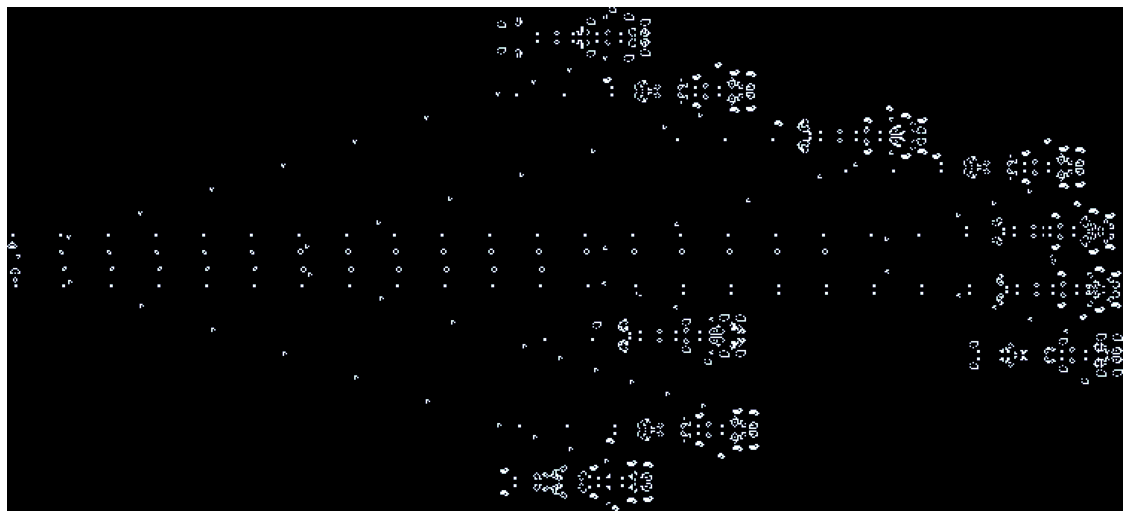

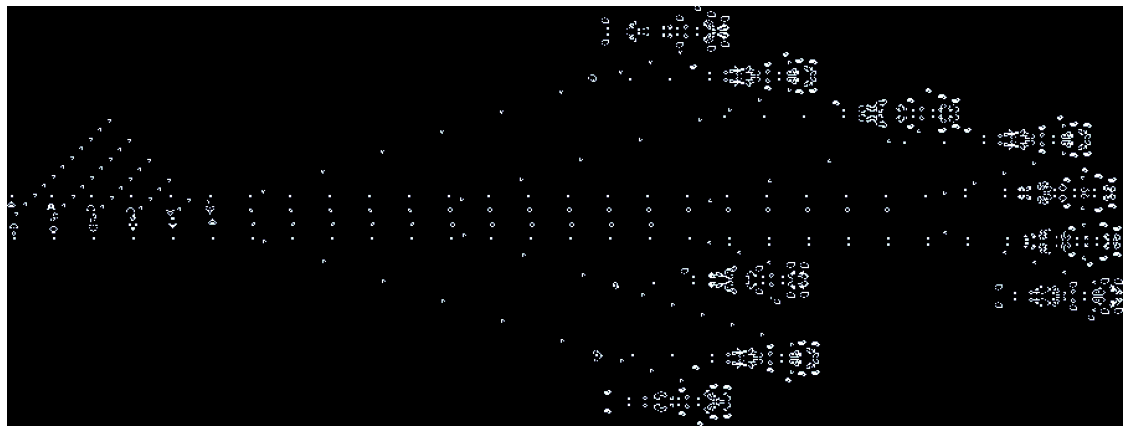

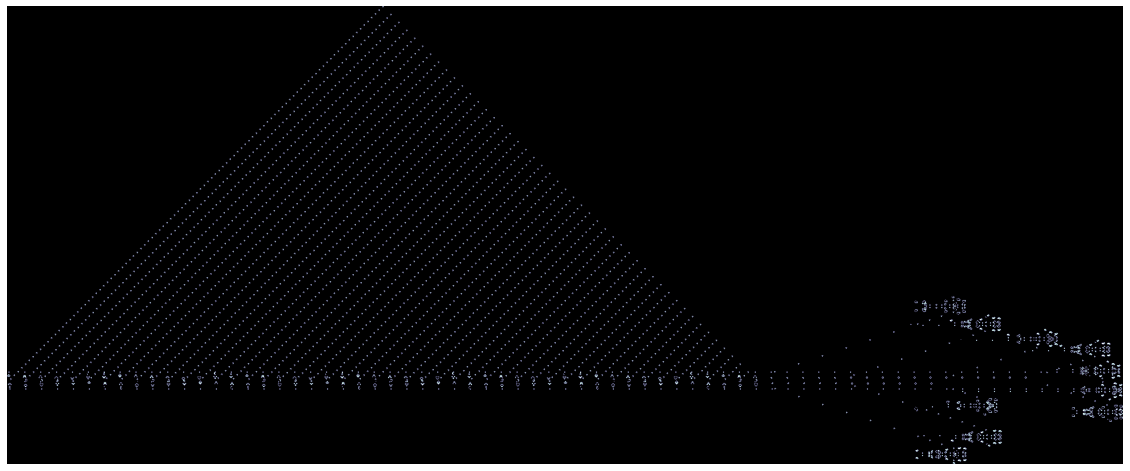

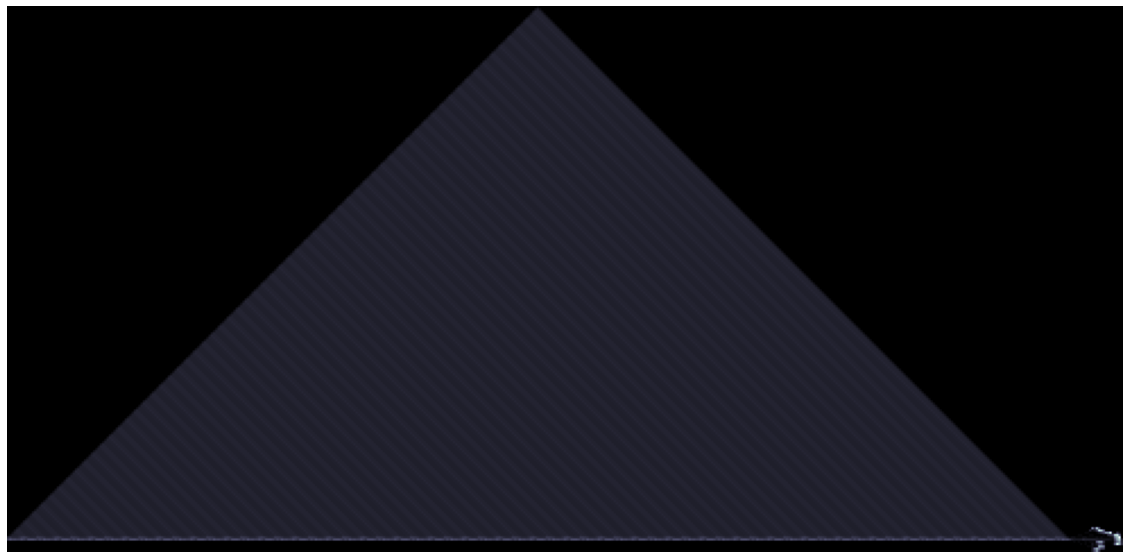

In [73]:

def construct(pts):
    """Turn a list of (x,y) coordinates into a quadtree"""
    # Force start at (0,0)
    min_x = min(*[x for x, y in pts])
    min_y = min(*[y for x, y in pts])
    pattern = {(x - min_x, y - min_y): on for x, y in pts}
    k = 0
    while len(pattern) != 1:
        # bottom-up construction
        next_level = {}
        z = get_zero(k)
        while len(pattern) > 0:
            x, y = next(iter(pattern))
            x, y = x - (x & 1), y - (y & 1)
            # read all 2x2 neighbours, removing from those to work through
            # at least one of these must exist by definition
            a = pattern.pop((x, y), z)
            b = pattern.pop((x + 1, y), z)
            c = pattern.pop((x, y + 1), z)
            d = pattern.pop((x + 1, y + 1), z)
            next_level[x >> 1, y >> 1] = join(a, b, c, d)
        # merge at the next level
        pattern = next_level
        k += 1
    return pattern.popitem()[1]


def expand(node, x=0, y=0, clip=None, level=0):
    """Turn a quadtree a list of (x,y,gray) triples 
    in the rectangle (x,y) -> (clip[0], clip[1]) (if clip is not-None).    
    If `level` is given, quadtree elements at the given level are given 
    as a grayscale level 0.0->1.0,  "zooming out" the display."""

    if node.n == 0:  # quick zero check
        return []
    size = 2 ** node.k
    # bounds check
    if clip is not None:
        if x + size < clip[0] or x > clip[1] or y + size < clip[2] or y > clip[3]:
            return []
    if node.k == level:
        # base case: return the gray level of this node
        gray = node.n / (size ** 2)
        return [(x >> level, y >> level, gray)]
    else:
        # return all points contained inside this node
        offset = size >> 1
        return (
            expand(node.a, x, y, clip, level)
            + expand(node.b, x + offset, y, clip, level)
            + expand(node.c, x, y + offset, clip, level)
            + expand(node.d, x + offset, y + offset, clip, level)
        )


def print_points(points):
    px, py = 0, 0
    for x, y, gray in sorted(points, key=lambda x: (x[1], x[0])):
        while y > py:
            print()
            py += 1
            px = 0
        while x > px:
            print(" ", end="")
            px += 1
        print("*", end="")


def is_padded(node):
    return (
        node.a.n == node.a.d.d.n
        and node.b.n == node.b.c.c.n
        and node.c.n == node.c.b.b.n
        and node.d.n == node.d.a.a.n
    )


def inner(node):
    """ Return the central portion of a node -- the inverse operation of centre() """
    return join(node.a.d, node.b.c, node.c.b, node.d.a)


def crop(node):
    """ Repeatedly take the inner node, until all padding is removed. """
    if node.k <= 3 or not is_padded(node):
        return node
    else:
        return crop(inner(node))


def pad(node):
    """ Repeatedly centre a node, until it is fully padded."""
    if node.k <= 3 or not is_padded(node):
        return pad(centre(node))
    else:
        return node


def ffwd(node, n):
    gens = 0
    for i in range(n):
        node = pad(node)
        gens += 1 << (node.k - 2)
        node = successor(node)
    return node, gens


def advance(node, n):
    if n == 0:
        return node
    bits = []
    while n > 0:
        bits.append(n & 1)
        n = n >> 1
        node = centre(node)
    for k, bit in enumerate(reversed(bits)):
        j = len(bits) - k - 1
        if bit:
            node = successor(node, j)
    return crop(node)


if __name__ == "__main__":
    from lifeparsers import autoguess_life_file
    import time

    # run the breeder forward many generations
    def load_lif(fname):
        pat, comments = autoguess_life_file(fname)
        return construct(pat)

    init_t = time.perf_counter()
    print(ffwd(load_lif("/Users/danielliu/Documents/GitHub/Conways-GoL/Python/lifep/BREEDER.LIF"), 300))
    t = time.perf_counter() - init_t
    print(f"Computation took {t*1000.0:.1f}ms")
    print(successor.cache_info())
    print(join.cache_info())

    import numpy as np
    import matplotlib.pyplot as plt

    ## utility to show a point collection as an image in Matplotlib
    def render_img(pts):
        pts = np.array(pts)
        pts[:, 0] -= np.min(pts[:, 0])
        pts[:, 1] -= np.min(pts[:, 1])
        grays = np.zeros((int(np.max(pts[:, 1] + 1)), int(np.max(pts[:, 0] + 1))))

        for x, y, g in pts:
            grays[int(y), int(x)] = g

        plt.figure(figsize=(20, 20))
        plt.imshow(grays, cmap="bone")
        plt.axis("off")

    ## test the Gosper glider gun
    pat = load_lif("/Users/danielliu/Documents/GitHub/Conways-GoL/Python/lifep/BREEDER.LIF")
    # pat = load_lif("/Users/danielliu/Documents/leetcode/Conway's/johnhwhashlife/lifep/gun30.lif")
    render_img(expand(pat))
    plt.savefig("breeder30_0.png", bbox_inches="tight")
    render_img(expand(advance(centre(centre(pat)), 300)))
    plt.savefig("breeder1500_gen.png", bbox_inches="tight")

    render_img(expand(advance(centre(centre(pat)), 3000), level=0))
    plt.savefig("breeder3000_gen.png", bbox_inches="tight")
    # render_img(expand(advance(centre(centre(pat)), 120), level=1))
    # plt.savefig("/Users/danielliu/Documents/GitHub/Conways-GoL/Python/lifep/BREEDER.LIF", bbox_inches="tight")
    # render_img(expand(advance(centre(centre(pat)), 120), level=2))
    # plt.savefig("/Users/danielliu/Documents/GitHub/Conways-GoL/Python/lifep/BREEDER.LIF", bbox_inches="tight")
    render_img(expand(advance(centre(centre(pat)), 30000), level=5))
    plt.savefig("breeder30000_level3.png", bbox_inches="tight")